In [1]:
# TsundereChen, 2020
# Import libraries first...
import os
import random
import pickle
from pathlib import Path

from mlgame.communication import ml as comm

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import DenseFeatures
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

In [2]:
# Create needed variables
pickleDir = "/MLgame/log"

Frame = []
Ball_X = []
Ball_Y = []
Ball_speed_X = []
Ball_speed_Y = []
Platform_1P_X = []
Platform_2P_X = []
Blocker_X = []
Command_1P = []
Command_2P = []
Command_1P_LEFT = []
Command_1P_NONE = []
Command_1P_RIGHT= []
Command_2P_LEFT = []
Command_2P_NONE = []
Command_2P_RIGHT= []

selectedFeatures = ["Ball_X",
             "Ball_Y",
             "Ball_speed_X",
             "Ball_speed_Y",
             "Platform_1P_X",
             "Blocker_X"]
selectedTargets = ["Command_1P"]

In [3]:
def movement(command):
    if command == "MOVE_LEFT":
        return -1
    elif command == "MOVE_RIGHT":
        return 1
    else: return 0

In [4]:
def readPickle(filename):
    frame = []
    ball_x = []
    ball_y = []
    ball_speed_x = []
    ball_speed_y = []
    platform_1P_x = []
    platform_2P_x = []
    blocker_x = []
    command_1P = []
    command_2P = []
    gameLog = pickle.load((open(filename, 'rb')))
    for sceneInfo in gameLog:
        frame.append(sceneInfo['frame'])
        ball_x.append(sceneInfo['ball'][0])
        ball_y.append(sceneInfo['ball'][1])
        ball_speed_x.append(sceneInfo['ball_speed'][0])
        ball_speed_y.append(sceneInfo['ball_speed'][1])
        platform_1P_x.append(sceneInfo['platform_1P'][0])
        platform_2P_x.append(sceneInfo['platform_2P'][0])
        blocker_x.append(sceneInfo['blocker'][0])
        command_1P.append(movement(sceneInfo['command_1P']))
        command_2P.append(movement(sceneInfo['command_2P']))
    return frame, \
           ball_x, \
           ball_y, \
           ball_speed_x, \
           ball_speed_y, \
           platform_1P_x, \
           platform_2P_x, \
           blocker_x, \
           command_1P, \
           command_2P

In [5]:
def readCommandPickle(filename):
    command_1P_LEFT = []
    command_1P_NONE = []
    command_1P_RIGHT= []
    command_2P_LEFT = []
    command_2P_NONE = []
    command_2P_RIGHT= []
    gameLog = pickle.load((open(filename, 'rb')))
    for sceneInfo in gameLog:
        if movement(sceneInfo['command_1P']) == 0:
            command_1P_LEFT.append(1)
            command_1P_NONE.append(0)
            command_1P_RIGHT.append(0)
        elif movement(sceneInfo['command_1P']) ==  1:
            command_1P_LEFT.append(0)
            command_1P_NONE.append(1)
            command_1P_RIGHT.append(0)
        elif movement(sceneInfo['command_1P']) ==  2:
            command_1P_LEFT.append(0)
            command_1P_NONE.append(0)
            command_1P_RIGHT.append(1)
        if movement(sceneInfo['command_2P']) == 0:
            command_2P_LEFT.append(1)
            command_2P_NONE.append(0)
            command_2P_RIGHT.append(0)
        elif movement(sceneInfo['command_2P']) == 1:
            command_2P_LEFT.append(0)
            command_2P_NONE.append(1)
            command_2P_RIGHT.append(0)
        elif movement(sceneInfo['command_2P']) == 2:
            command_2P_LEFT.append(0)
            command_2P_NONE.append(0)
            command_2P_RIGHT.append(1)
    return command_1P_LEFT, \
           command_1P_NONE, \
           command_1P_RIGHT, \
           command_2P_LEFT, \
           command_2P_NONE, \
           command_2P_RIGHT

In [6]:
def fileList(path):
    return os.listdir(path)

In [7]:
def importData():
    print("Importing...")
    global Frame
    global Ball_X
    global Ball_Y
    global Ball_speed_X
    global Ball_speed_Y
    global Platform_1P_X
    global Platform_2P_X
    global Blocker_X
    global Command_1P
    global Command_2P
    global Command_1P_LEFT
    global Command_1P_NONE
    global Command_1P_RIGHT
    global Command_2P_LEFT
    global Command_2P_NONE
    global Command_2P_RIGHT

    path = os.path.dirname(str(Path().resolve()))
    path = path + pickleDir
    files = fileList(path)
    for filename in files:
        fullpath = path + "/" + filename
        frame, ball_x, ball_y, ball_speed_x, ball_speed_y, platform_1P_x, platform_2P_x, blocker_x, command_1P, command_2P = readPickle(fullpath)
        command_1P_LEFT, command_1P_NONE, command_1P_RIGHT, command_2P_LEFT, command_2P_NONE, command_2P_RIGHT = readCommandPickle(fullpath)
        Frame += frame
        Ball_X += ball_x
        Ball_Y += ball_y
        Ball_speed_X += ball_speed_x
        Ball_speed_Y += ball_speed_y
        Platform_1P_X += platform_1P_x
        Platform_2P_X += platform_2P_x
        Blocker_X += blocker_x
        Command_1P += command_1P
        Command_2P += command_2P
    originalData = pd.DataFrame({'Frame':Frame,
        'Ball_X': Ball_X, 'Ball_Y': Ball_Y, 'Ball_speed_X': Ball_speed_X, 'Ball_speed_Y': Ball_speed_Y,
        'Platform_1P_X': Platform_1P_X, 'Platform_2P_X': Platform_2P_X, 'Blocker_X': Blocker_X,
        'Command_1P': Command_1P, 'Command_2P': Command_2P})
    print("Import done")
    originalData = originalData.reindex(np.random.permutation(originalData.index))
    trainingData = originalData.head(290000)
    validateData = originalData.tail(7000)
    return trainingData, validateData

In [8]:
def dataSummary(trainingData, validateData):
    print("Training samples summary:")
    print(trainingData.describe())
    print("Test samples summary:")
    print(validateData.describe())

In [9]:
def featureSelection(trainingData, validateData):
    trainingFeatures = trainingData[selectedFeatures]
    validateFeatures = validateData[selectedFeatures]
    return trainingFeatures, validateFeatures

In [10]:
def targetSelection(trainingData, validateData):
    trainingTargets = trainingData[selectedTargets]
    validateTargets = validateData[selectedTargets]
    return trainingTargets, validateTargets

In [11]:
def createFeatureColumns(inputFeatures):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in inputFeatures])

In [12]:
def createModelAdam(learningRate, featureNum):
    model = Sequential()
    model.add(Dense(units = featureNum, activation=None))
    # Hidden layers
    model.add(Dense(units = 32, activation='relu'))
    model.add(Dense(units = 16, activation='relu'))
    model.add(Dense(units = 8, activation='relu'))
    model.add(Dense(units = 4, activation='relu'))
    model.add(Dense(units = 2, activation='sigmoid'))
    #model.add(Dropout(rate=0.2))
    # Output layer
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(lr=learningRate),
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

In [13]:
def trainModel(model, feature, label, epochs, batchSize=None):
    # features = {name:np.array(value) for name, value in feature.items()}
    # labels = {name:np.array(value) for name, value in label.items()}
    history = model.fit(x = feature, y = label, batch_size = batchSize, epochs = epochs, shuffle = True)
    epochs = history.epoch

    hist = pd.DataFrame(history.history)
    accuracy = hist["accuracy"]
    return epochs, accuracy

In [14]:
def evaluateModel(model, feature, label, batchSize = None):
    # features = {name:np.array(value) for name, value in feature.items()}
    return model.evaluate(x = feature, y = label, batch_size = batchSize)

In [15]:
def plotLossCurve(epochs, accuracy):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.plot(epochs, accuracy, label="Accuracy")
    plt.legend()
    plt.ylim([accuracy.min()*0.95, accuracy.max()*1.03])
    plt.show()

In [16]:
trainingData, validateData = importData()
# Select features
trainingFeatures, validateFeatures = featureSelection(trainingData, validateData)
# Select targets
trainingTargets, validateTargets   = targetSelection(trainingData, validateData)

Importing...
Import done


Epoch 1/290
290/290 [==============================] - 0s 992us/step - loss: 0.3362 - accuracy: 0.6596
Epoch 2/290
290/290 [==============================] - 0s 983us/step - loss: 0.2946 - accuracy: 0.6596
Epoch 3/290
290/290 [==============================] - 0s 984us/step - loss: 0.2236 - accuracy: 0.6868
Epoch 4/290
290/290 [==============================] - 0s 984us/step - loss: 0.1188 - accuracy: 0.7686
Epoch 5/290
290/290 [==============================] - 0s 980us/step - loss: 0.1008 - accuracy: 0.7766
Epoch 6/290
290/290 [==============================] - 0s 981us/step - loss: 0.0913 - accuracy: 0.7820
Epoch 7/290
290/290 [==============================] - 0s 990us/step - loss: 0.0853 - accuracy: 0.7847
Epoch 8/290
290/290 [==============================] - 0s 982us/step - loss: 0.0813 - accuracy: 0.7872
Epoch 9/290
290/290 [==============================] - 0s 981us/step - loss: 0.0777 - accuracy: 0.7891
Epoch 10/290
290/290 [==============================] - 0s 988us/step - l

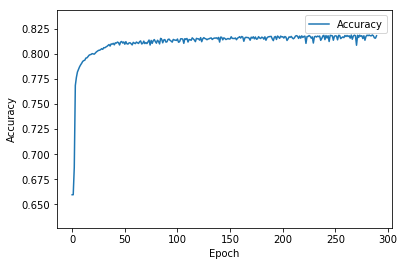


Evaluate the new model against validation set:
7/7 [==============================] - 0s 1ms/step - loss: 0.0190 - accuracy: 0.8197

Loss: 0.01895478367805481
Accuracy: 0.8197143077850342


In [17]:
learningRate = 0.003
epochs = 290
batchSize = 1000

featureNum = len(selectedFeatures)

model = createModelAdam(learningRate, featureNum)
epochs, accuracy = trainModel(model, trainingFeatures, trainingTargets, epochs, batchSize)
print(model.summary())

plotLossCurve(epochs, accuracy)

print("\nEvaluate the new model against validation set:")
loss, acc = evaluateModel(model, validateFeatures, validateTargets, batchSize)
print("\nLoss: {}\nAccuracy: {}".format(loss, acc))

In [18]:
print("Exporting model...")
model.save('saved_model/myModel')

Exporting model...


W0519 19:07:49.967932 139690068363008 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
